# Imports

In [1]:
import torch
from torch import nn, Tensor
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2
from PIL import Image
import numpy as np
from tqdm import tqdm
import sys
import warnings
import ipywidgets as widgets
from IPython.display import display, clear_output
import io

# Utils

In [2]:
# Accuracy function for binary classification
def accuracy(pred, y):
    pred = torch.sigmoid(pred)  # Convert logits to probabilities
    pred_binary = (pred > 0.5).float()  # Threshold at 0.5
    correct = pred_binary.eq(y).float().sum()
    return (correct / y.size(0)).item()  # Return scalar accuracy

In [3]:
def train_fn(train_dataloader, val_dataloader, model, loss_fn, optimizer, n_epochs, logs_dict, device):
    for epoch in range(n_epochs):
        model.train()
        for batch_idx, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            pred = model.forward(X)
            loss = loss_fn(pred.reshape(-1), y)
            acc = accuracy(pred.reshape(-1), y)

            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            sys.stdout.write(f'\rEpoch: {epoch} Train loss: {loss:.3f} Train Accuracy: {acc:.2f} Val loss: {torch.mean(Tensor(LOGS["tmp_val_loss"])).item():.3f} Val Accuracy: {torch.mean(Tensor(LOGS["tmp_val_acc"])).item():.2f}')
            sys.stdout.flush()
            logs_dict["train_loss"].append(loss.item())
            logs_dict["train_acc"].append(acc)
        model.eval()
        sys.stdout.write(f'\rEpoch: {epoch} Validation in progress')
        sys.stdout.flush()
        for batch_idx, (X_val, y_val) in enumerate(val_dataloader):
            with torch.no_grad():
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_pred = model.forward(X_val)
                val_loss = loss_fn(val_pred.reshape(-1), y_val)
                val_acc = accuracy(val_pred.reshape(-1), y_val)
                logs_dict["tmp_val_loss"].append(val_loss.item())
                logs_dict["tmp_val_acc"].append(val_acc)
                logs_dict["val_loss"].append(val_loss.item())
                logs_dict["val_acc"].append(val_acc)

In [4]:
class SafeImageFolder(torchvision.datasets.ImageFolder): # This class its ImageFolder but with broken image filtering 
    def __init__(self, root, transform=None, target_transform=None):
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.samples = [
            (path, class_idx) for path, class_idx in self.samples
            if self._is_valid_image(path)
        ]

    def _is_valid_image(self, path):
        try:
            with Image.open(path) as img:
                img.verify()
            return True
        except Exception:
            return False

In [5]:
LOGS = {
    "train_loss": [], 
    "train_acc": [], 
    "val_loss": [], 
    "val_acc": [], 
    "tmp_val_loss": [], 
    "tmp_val_acc": [],
    "test_loss": [],
    "test_acc": []
}

In [6]:
import warnings
warnings.filterwarnings(
    action='ignore',
    category=UserWarning,
)


# Dataset

In [7]:
BATCH_SIZE = 32

In [8]:
image_transforms = v2.Compose([v2.Resize((224, 224)), 
                        v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]) 

In [9]:
dataset = SafeImageFolder("./catsvsdogs", transform=image_transforms, target_transform=lambda x: torch.tensor(x, dtype=torch.float32))
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Model

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
num_in_features = model.fc.in_features
model.fc = nn.Linear(in_features=num_in_features, out_features=1, bias=True)
for param in model.parameters():
    param.requires_grad = True
model = model.to(device)

In [12]:
LR = 1e-3
EPOCH = 2

In [13]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [14]:
train_fn(train_dataloader, val_dataloader, model, loss_fn, optimizer, EPOCH, LOGS, device)

Epoch: 1 Validation in progressn Accuracy: 0.94 Val loss: 0.146 Val Accuracy: 0.93

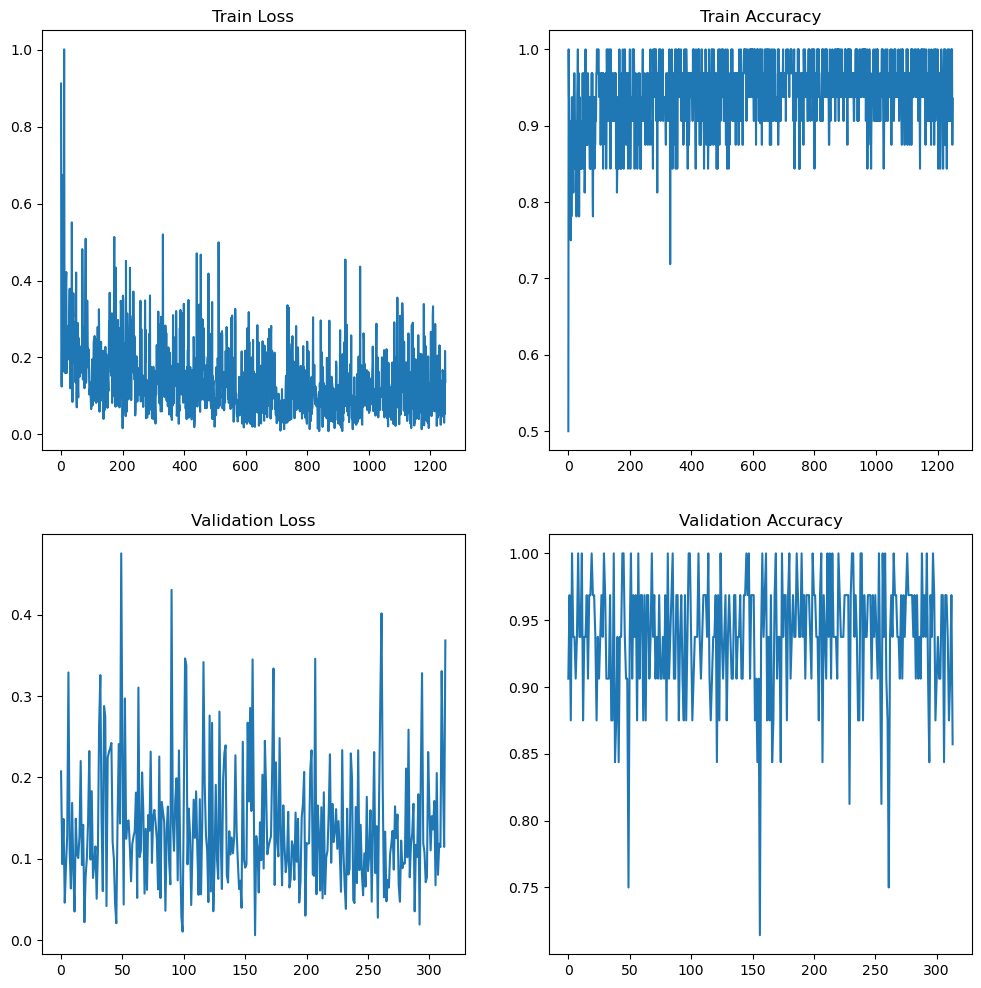

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
ax.flat[0].plot(LOGS["train_loss"])
ax.flat[0].set_title("Train Loss")

ax.flat[1].plot(LOGS["train_acc"])
ax.flat[1].set_title("Train Accuracy")

ax.flat[2].plot(LOGS["val_loss"])
ax.flat[2].set_title("Validation Loss")

ax.flat[3].plot(LOGS["val_acc"])
ax.flat[3].set_title("Validation Accuracy")

plt.show()

In [16]:
cpu_model = model.cpu()

# Prediction

### Form Setup

In [17]:
t1_output = widgets.Output()

image_id = widgets.BoundedIntText(
    value=7,
    min=0,
    max=len(val_dataset),
    step=1,
    description='Image id from dataset:',
    disabled=False,
    style={'description_width': 'initial'}
)
def t1_func(b):
    image_id_i = image_id.value
    cat_or_dog = lambda x: "Cat" if torch.tanh(x).item() <= 0 else "Dog"  
    with t1_output:
        clear_output()
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(val_dataset[image_id_i][0].permute(1, 2, 0).numpy())
        plt.title("Selected image")
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1, 2, 2)
        plt.axis('off')
        prediction = cpu_model(val_dataset[image_id_i][0].unsqueeze(0))
        info = f"""Raw Model Prediction: {prediction.item():.3f}

Model Prediction in Words: {cat_or_dog(prediction)}
Model Prediction Confidence: {torch.tanh(prediction).abs().item():.2%}"""

        plt.text(0, 1, info, fontsize=12, va='top')
        plt.tight_layout()
        plt.show()
        

t1_button = widgets.Button(description="Classify")
t1_button.on_click(t1_func)
t1 = widgets.VBox([image_id, t1_button, t1_output])

In [18]:
t2_output = widgets.Output()

image_file = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    desctiption="Image file Upload: "
)
def t2_func(b):
    filename = list(image_file.value.keys())[0]
    bytes_content = image_file.value[filename]['content']
    pil_image = Image.open(io.BytesIO(bytes_content))
    cat_or_dog = lambda x: "Cat" if torch.tanh(x).item() <= 0 else "Dog" 
    with t2_output:
        clear_output()
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(pil_image)
        plt.title("Selected image")
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1, 2, 2)
        plt.axis('off')
        prediction = cpu_model(image_transforms(pil_image).unsqueeze(0))
        info = f"""Raw Model Prediction: {prediction.item():.3f}

Model Prediction in Words: {cat_or_dog(prediction)}
Model Prediction Confidence: {torch.tanh(prediction).abs().item():.2%}"""

        plt.text(0, 1, info, fontsize=12, va='top')
        plt.tight_layout()
        plt.show()
t2_button = widgets.Button(description="Classify")
t2_button.on_click(t2_func)

t2 = widgets.VBox([image_file, t2_button, t2_output])

In [19]:
form = widgets.Tab()
form.children = [t1, t2]
form.set_title(0, 'Select from dataset')
form.set_title(1, 'Upload image file')

### Prediction form

In [20]:
display(form)